<a href="https://colab.research.google.com/github/TomMaullin/BLM/blob/master/GS_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GS implementation in python

This code implements the Gibbs Sampling algorithm for estimating the parameters of linear mixed effects models as described in [my pdf](https://www.overleaf.com/read/wytrsgqgxzsk).

## Pip Installations

Pip install everything.**bold text**

In [0]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib


## Python Imports




We need:
 - `numpy` for matrix handling.
 - `scipy` for sparse matrix functions.
 - `pandas` for quick reading and writing of csv files.
 - `os` and `sys` for basic commandline functions
 - `time` for timing functions.
 - `matplotlib` for making displays.

In [0]:
import numpy as np
import cvxopt
import pandas as pd
import os
import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.stats
from matplotlib.pyplot import imshow
import sys

## Helper Functions

This section contains miscellaneous functions used to help the `GS` function including functions to work out the duplication matrix.


## Toy Dataset

This section read ins and formats a toy dataset. The files used here were generated in `R` and with **True** values (those with postfix `True`) being those used to generate the data and **Estimated** (those with postfix `REst`) values being the estimates `R`'s `lmer` package generated from this data.

In [0]:
# Make a data directory
if not os.path.isdir('/Data'):
  os.mkdir('/Data')
  
os.chdir('/Data')

# Clone small git repo containg some csv files.
if not os.path.isdir('/Data/BLMM-testdata'):
  !git clone https://github.com/TomMaullin/BLMM-testdata.git
  


### Z matrix

The below reads in Z and makes an image of Z transpose.


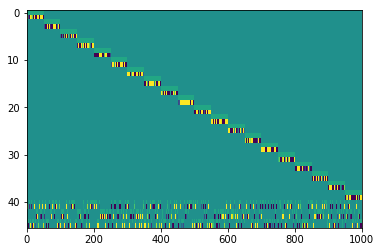

In [0]:
# Read in random effects design matrix and convert it into it's sparse format in
# cvxopt.
Z_3col=pd.read_csv('/Data/BLMM-testdata/Z_3col.csv',header=None).values
Z = scipy.sparse.csr_matrix((Z_3col[:,2].tolist(), \
                            ((Z_3col[:,0]-1).astype(np.int64), \
                             (Z_3col[:,1]-1).astype(np.int64))))

# Create an image of Z'
imshow(Z.toarray().transpose(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')



### Estimated Random Effects matrix

The below reads in the Random effects variance predicted by `R`'s `lmer`.

In [0]:
# Read in estimated variance
RFXVar_REst = pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values

### Y vector

The response vector is read in here:

In [0]:
Y=pd.read_csv('/Data/BLMM-testdata/Y.csv',header=None).values

### X matrix

The fixed effects design matrix is read in here. It consists of an intercept and two random (Gaussian) columns.


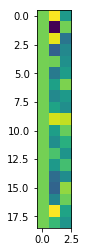

In [0]:
X=pd.read_csv('/Data/BLMM-testdata/X.csv',header=None).values

# Image of the first 20 rows of X
imshow(X[1:20,:])

### Number of Levels and Parameters

The number of levels is given by a vector with one entry for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2. 

The number of parameters is given by a vector with one entry for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

In [0]:
nlevels = np.array([20,3])
nparams = np.array([2,2])

### True b values

The true recorded values of the random effects b vector in this example.

In [0]:
b_True=pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values

### True beta values

The true fixed effects parameters used to generate this example.

In [0]:
beta_True=pd.read_csv('/Data/BLMM-testdata/true_beta.csv',header=None).values

### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. 

In [0]:
# Z transpose Z
ZtZ = Z.transpose()*Z # This works for products involving sparse

# Z transpose X
XtZ = X.transpose()*Z

# XtX
XtX = np.matmul(X.transpose(),X)

## Perform Gibb's Sampling

This section contains the function which performs Gibb's sampling for the linear mixed model


In [0]:
def GS(XtX,XtY,XtZ,ZtY,YtY, beta0, u0, sigma_ffx0, sigma_rfx0, nit, n, nparams, nlevels):
  
  # Estimators of the population parameters
  uhat = 0
  betahat = 0
  sigmahat_ffx = 0
  
  # Number of grouping factors
  r = nlevels.shape[0]
  
  # We have a matrix estimate for each grouping factor
  # variance matrix
  sigmahat_rfx = dict()
  for i in range(r):
    sigmahat_rfx[i] = np.zeros((nparams[i],nparams[i]))
  
  # Current values
  beta_curr = beta0
  u_curr = u0
  sigma_ffx_curr = sigma_ffx0
  sigma_rfx_curr = sigma_rfx0  
  
  # Average values
  beta_avg = np.zeros(beta0.shape)
  u_avg = np.zeros(u0.shape)
  sigma_ffx_avg = 0
  sigma_rfx_avg = dict()
  for i in range(r):
    sigma_rfx_avg_i = np.zeros((nparams[i],nparams[i]))
    sigma_rfx_avg[i] = sigma_rfx_avg_i
  
  
  
  # Constants needed for priors
  b = 2
  v = nparams+2
  A = dict()
  for i in range(r):
    A_tmp = np.eye(nparams[i])
    A_tmp[A_tmp==0]=0.5
    A[i] = A_tmp
  
  # Run the number of iterations
  for i in range(nit):
    
    # Current mean/variance of beta
    betamean = np.matmul(np.linalg.inv(XtX),(XtY-np.matmul(XtZ,u_curr)))
    betamean = betamean.reshape(betamean.shape[0])
    betavar = sigma_ffx_curr*np.linalg.inv(XtX)
    
    # New estimate of beta
    beta_curr = np.random.multivariate_normal(betamean, betavar)
    beta_curr = beta_curr.reshape(beta_curr.shape[0],1)
    
    # Update average
    beta_avg = beta_avg + beta_curr
    
    # D inverse
    Dinv = np.zeros((np.dot(nparams,nlevels),np.dot(nparams,nlevels)))
      
    # Top right hand index of next block to be filled
    TRHind=0
    
    for j in range(r):
      
      # Current sigma_rfx block
      sigma_rfx_curr_j = sigma_rfx_curr[j]
      
      # Work out the next block
      DinvBlock = np.linalg.inv(sigma_rfx_curr_j)
      
      # This gets repeated for the number of levels for factor j
      for k in range(nlevels[j]):
        
        # Indices for current block
        blockIndices = np.ix_(TRHind+np.arange(nparams[j]),TRHind+np.arange(nparams[j]))
        
        Dinv[blockIndices] = DinvBlock
        
        # Move Top Right hand index to next block
        TRHind = TRHind + nparams[j]
    
    # Current mean/variance for u
    umean = np.matmul(np.linalg.inv(ZtZ.toarray()+sigma_ffx_curr*Dinv),(ZtY-np.matmul(XtZ.transpose(),beta_curr).reshape(ZtY.shape)))
    umean = umean.reshape(umean.shape[0])
    uvar = np.linalg.inv(ZtZ.toarray()+sigma_ffx_curr*Dinv)*sigma_ffx_curr
    
    # New estimate of u
    u_curr = np.random.multivariate_normal(umean, uvar)
    u_curr = u_curr.reshape(u_curr.shape[0], 1)
    
    # Update average
    u_avg = u_avg + u_curr
    
    # Residual sum of squares (Y-Xbeta-Zu)'(Y-Xbeta-Zu)
    rss_curr = YtY + np.matmul(np.matmul(u_curr.transpose(), ZtZ.toarray()),u_curr) + \
          np.matmul(np.matmul(beta_curr.transpose(), XtX),beta_curr) - \
          2*np.matmul(beta_curr.transpose(), XtY) - \
          2*np.matmul(u_curr.transpose(), ZtY) + \
          2*np.matmul(np.matmul(beta_curr.transpose(), XtZ),u_curr)
    
    # New estimate of fixed effects vairance
    sigma_ffx_curr = scipy.stats.invgamma.rvs(a=(b+(n/2)), scale=rss_curr[0]/2, size=1)
    
    # Update average
    sigma_ffx_avg = sigma_ffx_avg + sigma_ffx_curr
    
    # Index of the first value in the next uj
    uj_ind = 0
    for j in range(r):
      
      # Current sigma_rfx block
      sigma_rfx_curr_j = sigma_rfx_curr[j]
      
      # Work out the indices of uj we need
      uj_indices = uj_ind + np.arange(nparams[j]*nlevels[j]) 
      
      # Get u for this grouing factor
      uj_curr = u_curr[uj_indices]
      
      # Initialis sum of uut 
      suut = np.zeros(nparams[j],nparams[j])
      
      # Now we need sum ujl*ujl' over each level l
      for l in range(nlevels[j]):
      
        # Work out the uj observations for level k
        ujl_curr = uj_curr[np.arange(nparams[j])+nparams[j]*l]
        suut = suut + np.matmul(ujl_curr,ujl_curr.transpose())
      
      # Work out parameters to sample new sigma_rfx block from inverse wishart
      sigma_rfx_curr_j_scalematrix = A[j] + suut
      sigma_rfx_curr_j_df = v[j] + nlevels[j]
      
      # Sample new variance block from inverse wishart
      sigma_rfx_curr[j] = scipy.stats.invwishart.rvs(df=sigma_rfx_curr_j_df, scale=sigma_rfx_curr_j_scalematrix)
      
      # Work out average
      sigma_rfx_avg[j] = sigma_rfx_avg[j] + sigma_rfx_curr[j]
      
      # Update index
      uj_ind = uj_ind + nparams[j]*nlevels[j]
      
  
  # Convert sums to averages
  beta_avg = beta_avg/nit
  sigma_ffx_avg = sigma_ffx_avg/nit
  u_avg = u_avg/nit
  for j in range(r):
    sigma_rfx_avg[j] = sigma_rfx_avg[j]/nit
    
  return(beta_avg, sigma_ffx_avg, u_avg, sigma_rfx_avg)
  

# Example

# Product matrices
XtX = np.matmul(X.transpose(),X)
XtY = np.matmul(X.transpose(),Y)
XtZ = np.matmul(X.transpose(),Z.toarray())
ZtY = np.matmul(Z.toarray().transpose(),Y)
YtY = np.matmul(Y.transpose(),Y)

# Number of subjects,n
n = 1000

# Initial values

# RFX variance
r = nlevels.shape[0]
sigma0_rfx = dict()
for i in range(r):
  sigma0_rfx[i] = np.eye(nparams[i],nparams[i])

# FFX variance
sigma0_ffx = 1

# Beta
beta0 = np.zeros((X.shape[1],1))

# u
u0 = np.zeros((Z.shape[1],1))

t1=time.time()
estimates=GS(XtX,XtY,XtZ,ZtY,YtY,beta0, u0, sigma0_ffx, sigma0_rfx, 1000, n, nparams, nlevels)
t2=time.time()
print(t2-t1)

print("Results after 1000 iterations")
print("-----------------------------")
print("Beta estimates (Gibbs)")
print(estimates[0])
print("Beta estimates (R)")
print(pd.read_csv('/Data/BLMM-testdata/estd_beta.csv',header=None).values)
print("Beta true")
print(beta_True)
print("-----------------------------")
print("U estimates (Gibbs)")
print(estimates[2].reshape(23,2))
print("U estimates (R)")
print(pd.read_csv('/Data/BLMM-testdata/estd_b.csv',header=None).values.reshape(23,2))
print("U true")
print(pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values.reshape(23,2))
print("-----------------------------")
print("Random effects variance estimates (Gibbs)")
print("Factor 1")
print(estimates[3][0])
print("Factor 2")
print(estimates[3][1])
print("Random effects variance estimates (R)")
estd_rfxvar=pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values
print("Factor 1")
print(estd_rfxvar[np.ix_(np.arange(2),np.arange(2))])
print("Factor 2")
print(estd_rfxvar[np.ix_(np.arange(2)+2,np.arange(2)+2)])
print("Random effects variance true")
true_rfx_3col=pd.read_csv('/Data/BLMM-testdata/true_rfxvar_3col.csv',header=None).values
true_rfx = scipy.sparse.csr_matrix((true_rfx_3col[:,2].tolist(), \
                            ((true_rfx_3col[:,0]-1).astype(np.int64), \
                             (true_rfx_3col[:,1]-1).astype(np.int64))))
print("Factor 1")
print(true_rfx[np.ix_(np.arange(2),np.arange(2))].toarray())
print("Factor 2")
print(true_rfx[np.ix_(np.arange(2)+40,np.arange(2)+40)].toarray())

4.513150453567505
Results after 1000 iterations
-----------------------------
Beta estimates (Gibbs)
[[0.5464067 ]
 [1.98512161]
 [3.03201756]]
Beta estimates (R)
[[1.04778749]
 [1.98321039]
 [3.03156038]]
Beta true
[[1]
 [2]
 [3]]
-----------------------------
U estimates (Gibbs)
[[-0.16641273 -4.2168499 ]
 [ 1.4136973   1.41212541]
 [ 1.59112192 -1.58888116]
 [ 1.5582383   0.40464328]
 [ 1.3003867   0.93790526]
 [-1.20813631  2.19750368]
 [-0.62719399 -1.18432693]
 [-0.90428168 -1.34791901]
 [ 0.20105858  2.53792982]
 [-0.58205751 -3.43663566]
 [ 1.33329767  0.10709062]
 [-1.21503839 -2.43700162]
 [ 0.63534816  1.33610731]
 [-0.99885399 -0.08067159]
 [ 1.44451179  2.19572301]
 [-1.26277561  4.30747634]
 [ 0.2658458   0.87146507]
 [-0.7912232  -3.16064885]
 [-1.48857717 -0.24107696]
 [-0.47916287  3.13871743]
 [ 2.31250477  0.64337653]
 [ 2.57262529 -0.15742232]
 [-6.8652865   0.4375333 ]]
U estimates (R)
[[-0.16266309 -4.21724427]
 [ 1.41643004  1.41243783]
 [ 1.59527575 -1.58921871]